In [2]:
from commonfunctions import *
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
target_img_size = (256, 256)

In [4]:
cow_select=io.imread('images-to-be-tested/cow_with_selection.png')
garb_select=io.imread('images-to-be-tested/garbage_with_selection.png')

cow_orig=io.imread('images-to-be-tested/cow.jpg')
garb_orig=io.imread('images-to-be-tested/garbage.jpg')

In [5]:
# cow_resized_img=cv2.resize(cow_select,target_img_size)
garb_sel_resize=cv2.resize(garb_select,target_img_size)

# cow_sel_resized=rgba2rgb(cow_resized_img)
garb_sel_conversion=rgba2rgb(garb_sel_resize)

# cow_resized_orig=cv2.resize(cow_orig,target_img_size)
garb_resized_orig=cv2.resize(garb_orig,target_img_size)

#for colors only:
#normalized_garb_resized_img = (garb_resized_orig - np.min(garb_resized_orig)) / (np.max(garb_resized_orig) - np.min(garb_resized_orig))


# print(normalized_garb_resized_img)
# print(garb_sel_conversion)

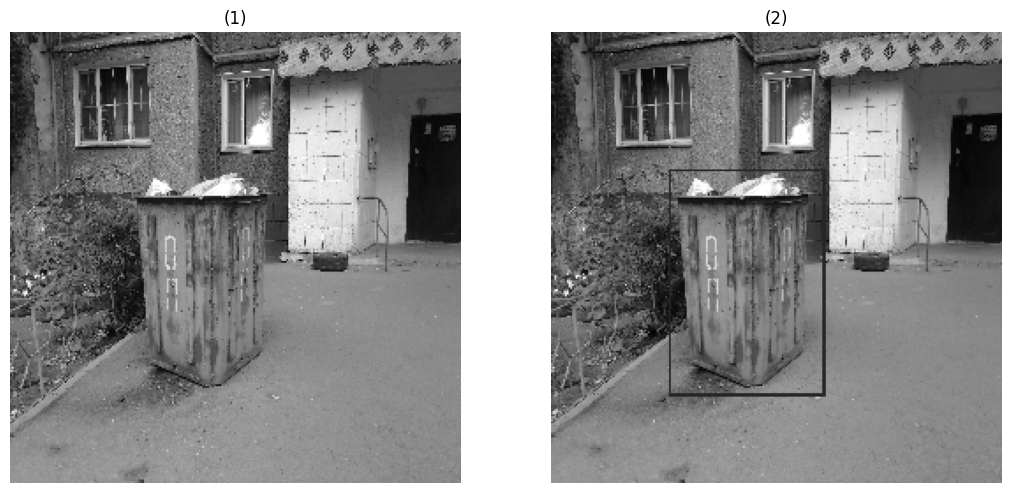

In [6]:
gray_orig_garb=rgb2gray(garb_resized_orig)
gray_sel_garb=rgb2gray(garb_sel_conversion)
show_images(images=[gray_orig_garb, gray_sel_garb])

Step 1: Finding difference between both image

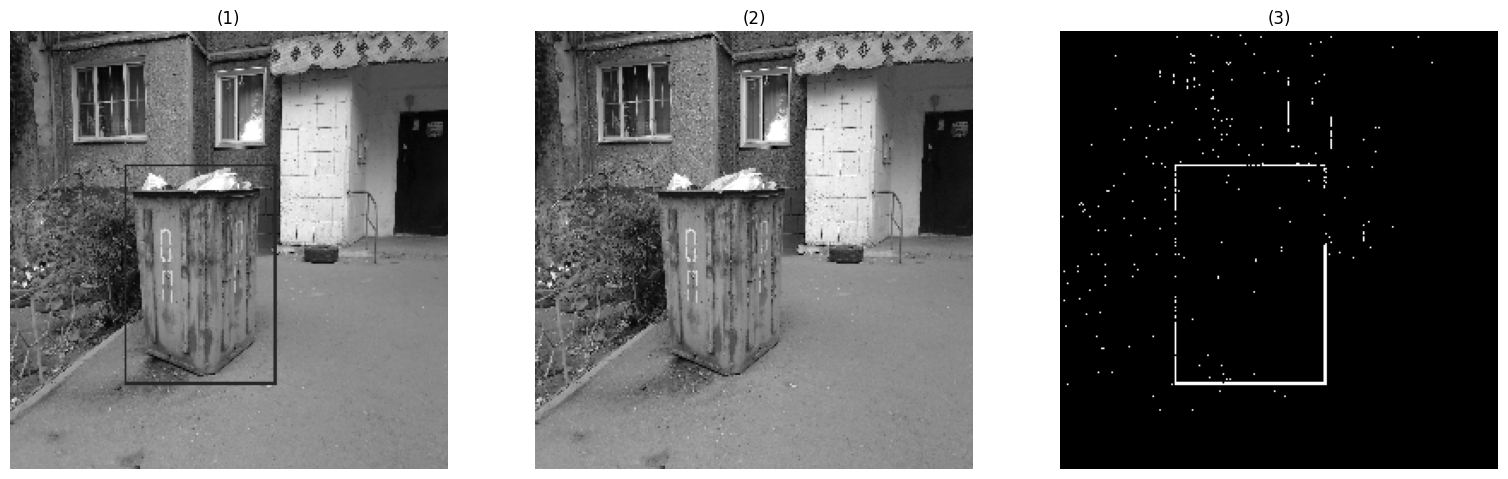

In [7]:
diff_garb = np.abs(gray_sel_garb - gray_orig_garb)

# Brightness Adjustment
result_garb=np.zeros((gray_sel_garb.shape))
result_garb[diff_garb>0.1]=1
#result_image_garb = np.where(difference_image_garb > 0.09, 1, garb_resized_orig)

show_images(images=[gray_sel_garb,gray_orig_garb,result_garb])

Step 2: Morphology:

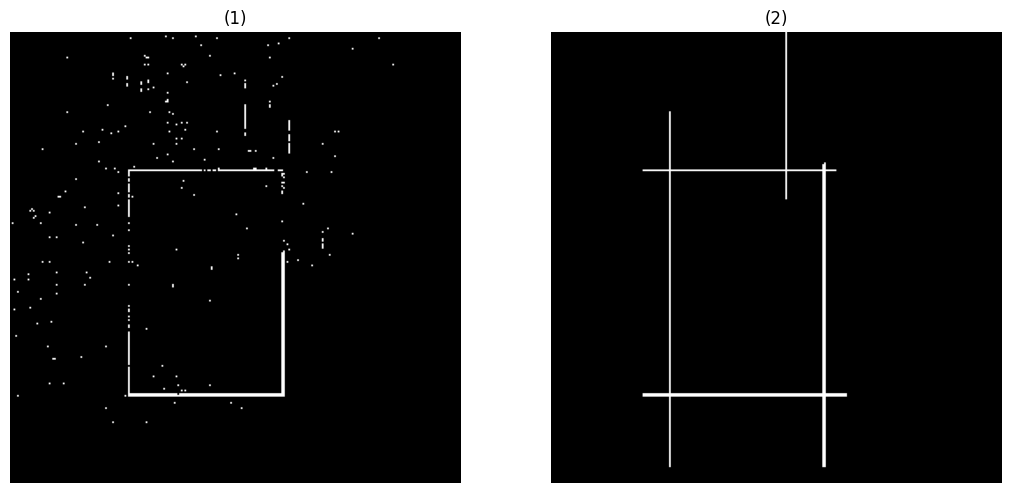

In [8]:
# we will use dilation to connect the disconnected edges:
#se=np.ones((15,15))
#se2=np.ones((3,3))
#rectangular_se = rectangle(20, 20)    # we might later need to adjust this dynamically using bounding boxes to know width and height of rectangle


se_vertical = rectangle(1, 10)
se_horizontal = rectangle(10,1)

# Apply erosion and dilation separately for vertical and horizontal lines
lines_vertical = binary_erosion(result_garb, footprint=se_vertical)
lines_vertical = binary_dilation(lines_vertical, footprint=se_vertical)
lines_vertical = binary_dilation(lines_vertical, footprint=se_vertical)
lines_vertical = binary_dilation(lines_vertical, footprint=se_vertical)
lines_vertical = binary_dilation(lines_vertical, footprint=se_vertical)   # additional one to cow image


lines_horizontal = binary_erosion(result_garb, footprint=se_horizontal)
lines_horizontal = binary_dilation(lines_horizontal, footprint=se_horizontal)
lines_horizontal = binary_dilation(lines_horizontal, footprint=se_horizontal)
lines_horizontal = binary_dilation(lines_horizontal, footprint=se_horizontal)
lines_horizontal = binary_dilation(lines_horizontal, footprint=se_horizontal)
lines_horizontal = binary_dilation(lines_horizontal, footprint=se_horizontal)
lines_horizontal = binary_dilation(lines_horizontal, footprint=se_horizontal)
lines_horizontal = binary_dilation(lines_horizontal, footprint=se_horizontal)
lines_horizontal = binary_dilation(lines_horizontal, footprint=se_horizontal)
lines_horizontal = binary_dilation(lines_horizontal, footprint=se_horizontal)
lines_horizontal = binary_dilation(lines_horizontal, footprint=se_horizontal)
lines_horizontal = binary_dilation(lines_horizontal, footprint=se_horizontal)

# Combine the results to get connected vertical and horizontal lines
connected_lines = lines_vertical | lines_horizontal


#morp_garb=eroded_garb
morp_garb=connected_lines
#dilated_garb_2=dilation(eroded_garb,se2)
show_images(images=[result_garb,morp_garb])

Step 3: Edge detection

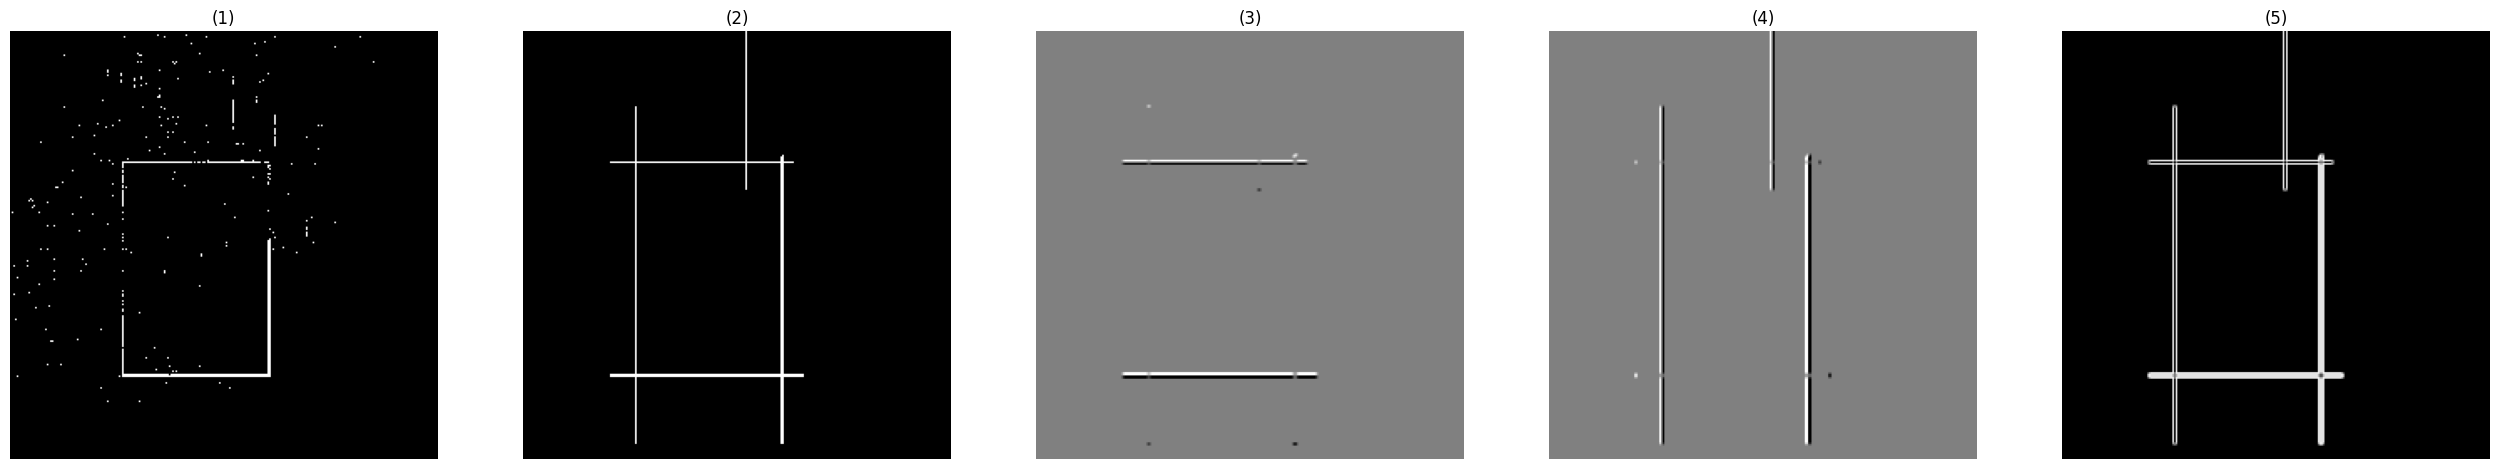

In [9]:
#sobel:
garb_sobel_x = sobel_h(morp_garb)  # Sobel operator for horizontal edges
garb_sobel_y = sobel_v(morp_garb)  # Sobel operator for vertical edges

# Combine the horizontal and vertical edges to get the magnitude
garb_sobel_magnitude = np.sqrt(garb_sobel_x**2 + garb_sobel_y**2)

show_images(images=[result_garb,morp_garb, garb_sobel_x, garb_sobel_y, garb_sobel_magnitude])

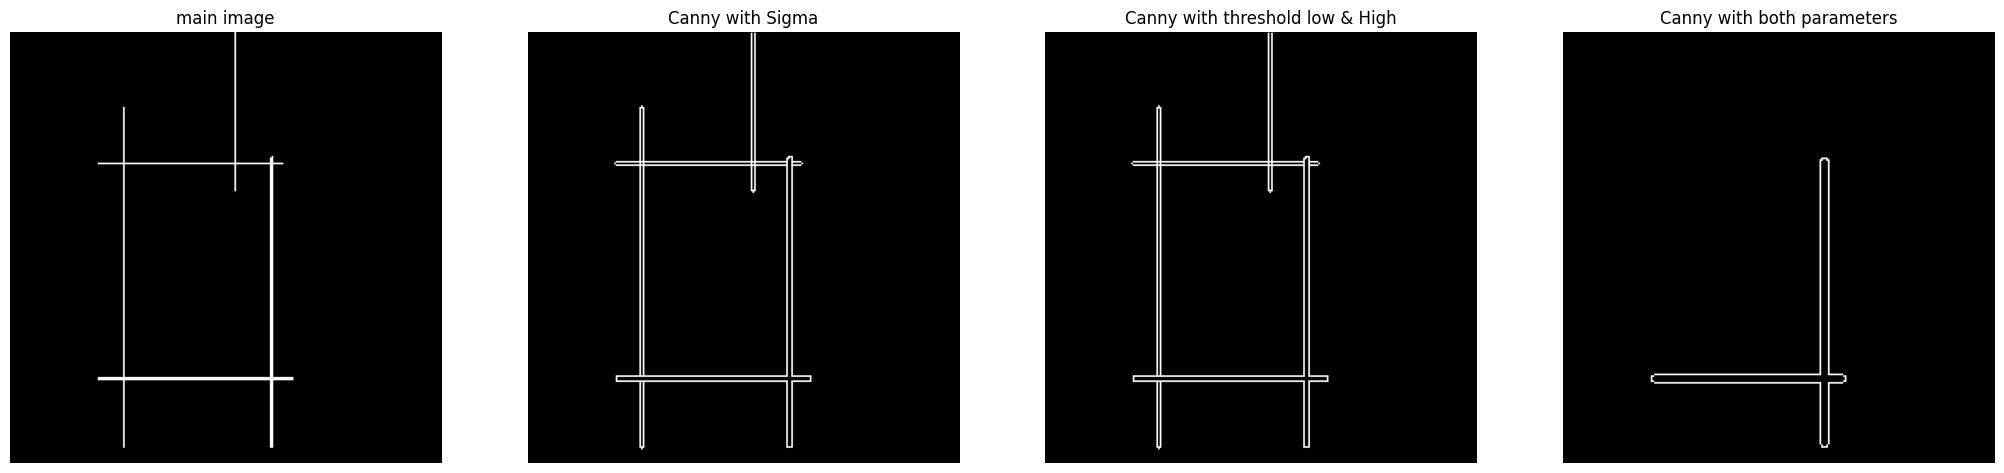

In [10]:
# Edge Detection

garb_canny_img_sigma=canny(morp_garb, sigma=1)  # increasing sigma detects stronger edges
garb_canny_with_both_threshold=canny(morp_garb, high_threshold=0.8, low_threshold=0.5)
garb_canny_with_both_par=canny(morp_garb, sigma=2, high_threshold=0.8, low_threshold=0.5)


show_images(images=[morp_garb,garb_canny_img_sigma ,garb_canny_with_both_threshold, garb_canny_with_both_par], titles=["main image","Canny with Sigma","Canny with threshold low & High", "Canny with both parameters"])


Step 4: Hough Transform 

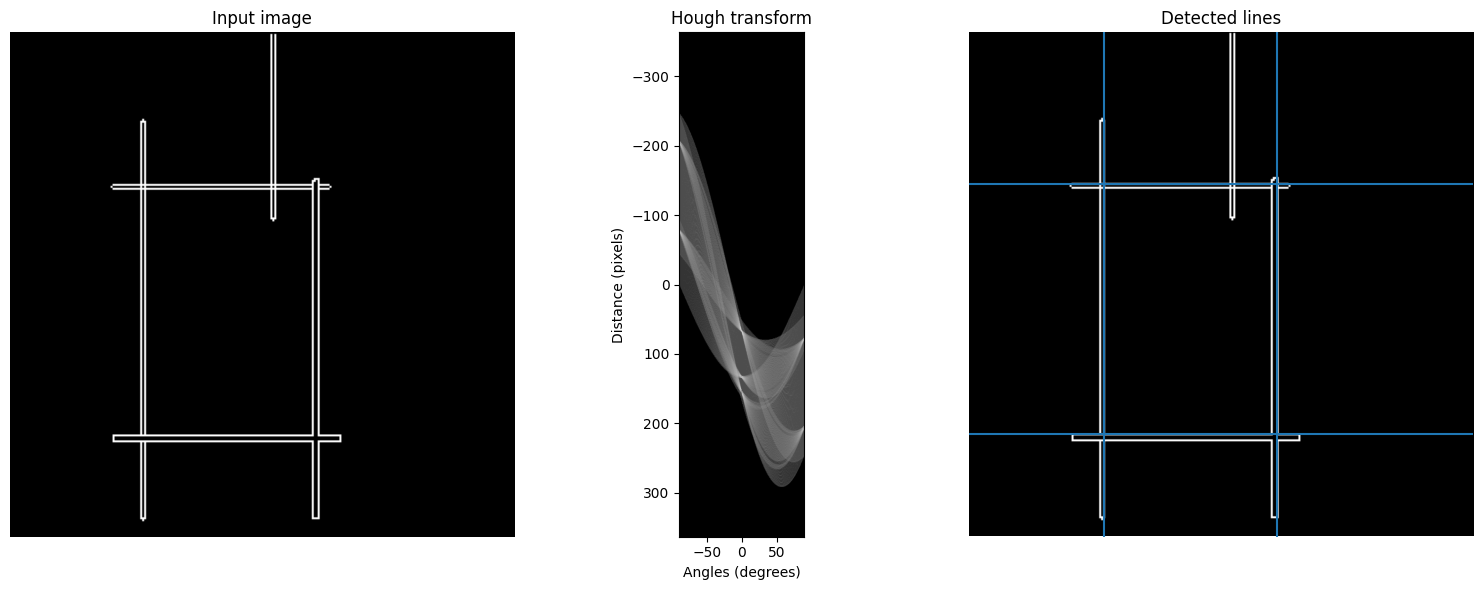

[(68.0, 204.0), (68.0, 77.0), (156.0, 204.0), (156.0, 77.0)]


In [11]:
#Given points (xi ,yi) find (R,θ)
'''
1. Parameter space is divided into accumulator cells A, all, initially, set to zero. 
2. For every point p(x,y) in image, change m in the range and calculate c. 
        C= - xm + y
3. A(m, c) = A(m, c) + 1 

At the end the value of A(mi , cj ) corresponds to the number of points that lie on the line: y = - mi x + cj

'''
image=garb_canny_img_sigma

# Classic straight-line Hough transform
# Set a precision of 0.5 degree.
tested_angles = np.linspace(-np.pi / 2, np.pi / 2, 360, endpoint=False)
h, theta, d = hough_line(image, theta=tested_angles)


# Generating figure 1
fig, axes = plt.subplots(1, 3, figsize=(15, 6))
ax = axes.ravel()
ax[0].imshow(image, cmap=cm.gray)
ax[0].set_title('Input image')
ax[0].set_axis_off()


angle_step = 0.5 * np.diff(theta).mean()
d_step = 0.5 * np.diff(d).mean()
bounds = [np.rad2deg(theta[0] - angle_step),
          np.rad2deg(theta[-1] + angle_step),
          d[-1] + d_step, d[0] - d_step]


ax[1].imshow(np.log(1 + h), extent=bounds, cmap=cm.gray, aspect=1 / 1.5)
ax[1].set_title('Hough transform')
ax[1].set_xlabel('Angles (degrees)')
ax[1].set_ylabel('Distance (pixels)')
ax[1].axis('image')

ax[2].imshow(image, cmap=cm.gray)
ax[2].set_ylim((image.shape[0], 0))
ax[2].set_axis_off()
ax[2].set_title('Detected lines')



# Find intersection points
intersection_points = []


# the vertical lines will have a theta of around 0 or around 180; the horizontal lines will have a theta of around 90.
# Filter lines based on orientation
vertical_lines = []
horizontal_lines = []


for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
    (x0, y0) = dist * np.array([np.cos(angle), np.sin(angle)])
    #lines.append((x0, y0))
    if np.degrees(angle) % 180 == 0:  # Check if the line is approximately vertical
        vertical_lines.append((x0, y0))
    elif np.degrees(angle) % 90 == 0:  # Check if the line is approximately horizontal
        horizontal_lines.append((x0, y0))

    ax[2].axline((x0, y0), slope=np.tan(angle + np.pi/2))


# Find intersection points between vertical and horizontal lines
for v_line in vertical_lines:
    for h_line in horizontal_lines:
        intersection_points.append((v_line[0], h_line[1]))



# print(points) :  [(68.0, 0.0), (156.0, 0.0), (-1.2491397351303002e-14, 204.0), (-4.7148901767173095e-15, 77.0)]

plt.tight_layout()
plt.show()


print(intersection_points)


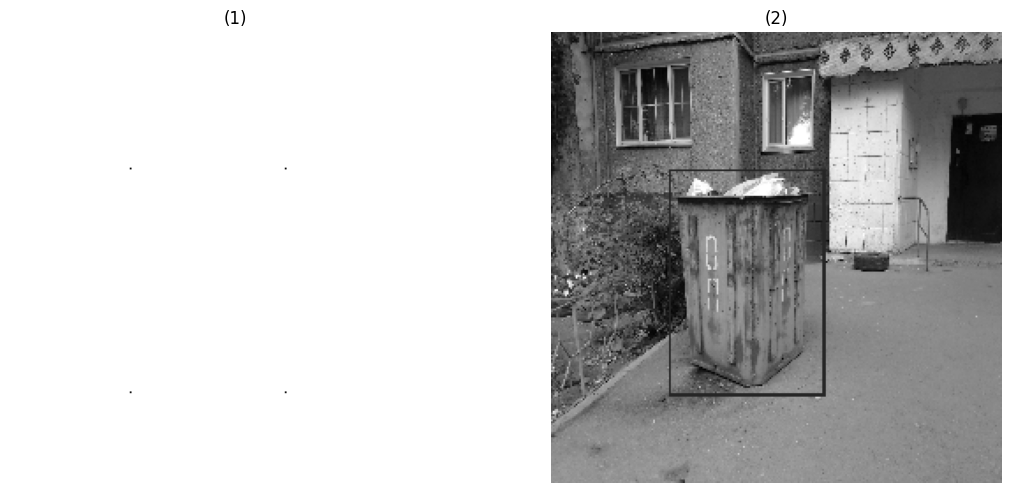

In [12]:
test_size = (256, 256)
test = np.ones((test_size))


# Coordinates of four white dots
coordinates = [(68.0, 204.0), (68.0, 77.0), (156.0, 204.0), (156.0, 77.0)]

# Convert coordinates to integers
coordinates = [(int(x), int(y)) for x, y in coordinates]

# Set the values at the coordinates to 1 (white)
for x, y in coordinates:
    test[y, x] = 0  # Note: y comes first in indexing for images

show_images(images=[test,gray_sel_garb])


Step 5: Extracting ROI 

156
68
204
77


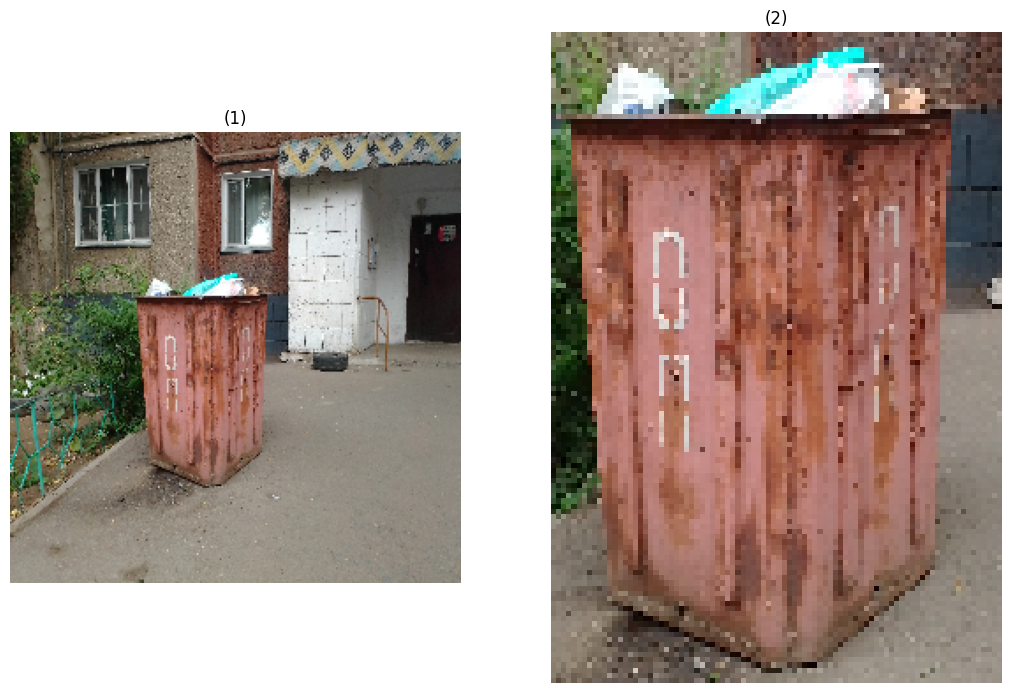

[[[133 127 101]
  [173 167 143]
  [140 135 106]
  ...
  [ 84  53  48]
  [ 81  52  46]
  [ 75  46  38]]

 [[131 130  98]
  [134 131 103]
  [136 129 103]
  ...
  [ 98  67  62]
  [ 97  68  64]
  [ 81  52  46]]

 [[126 133  88]
  [131 136  99]
  [147 141 117]
  ...
  [ 89  59  51]
  [ 80  50  42]
  [ 66  37  33]]

 ...

 [[135 123 107]
  [139 127 113]
  [121 109  93]
  ...
  [140 133 123]
  [154 147 137]
  [156 149 139]]

 [[138 126 110]
  [115 103  89]
  [133 121 105]
  ...
  [153 147 137]
  [153 146 136]
  [152 145 137]]

 [[125 112  98]
  [ 87  75  61]
  [110  99  81]
  ...
  [158 149 140]
  [152 145 135]
  [151 144 136]]]


In [17]:
our_img=garb_resized_orig
#print(coordinates) #[(221, 72), (221, 216), (51, 72), (51, 216)]

top_left , top_right, bottom_left, bottom_right= coordinates
y1=bottom_left[1]  #72
y2=bottom_right[1] #216
x1=bottom_right[0] #51
x2=top_right[0]  #221
print(x1)
print(x2)
print(y1)
print(y2)

subimage = our_img[ y2:y1 , x2:x1]   # fe 7aga mo5tlfa hena 3n el cow?

show_images(images=[our_img, subimage])
print(subimage[:,:,:])

Step 6: Region Based Segmentation

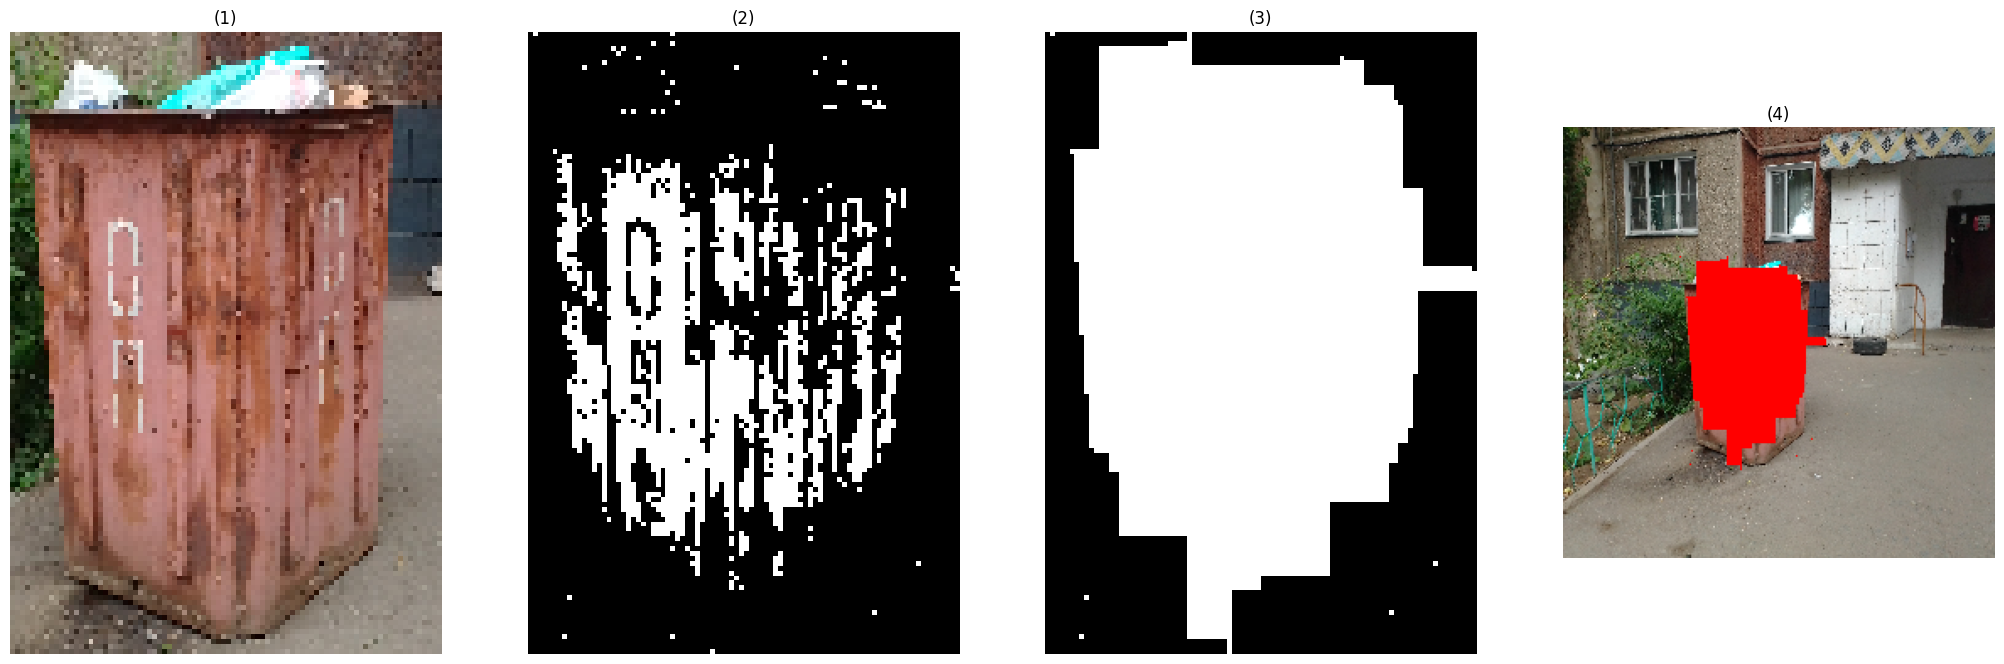

In [19]:
# Get the dimensions of the image
height, width, channels = subimage.shape

# consider it the middle pixel for now:  "will be given by user later"
# Calculate the middle pixel coordinates
middle_pixel_x = width // 2
middle_pixel_y = height // 2
# Get the RGB values of the middle pixel
middle_pixel_rgb = subimage[middle_pixel_y, middle_pixel_x]

# seed point 
seed= (middle_pixel_x,middle_pixel_y)
# seed color:
seed_color= middle_pixel_rgb



# paper: https://link.springer.com/referenceworkentry/10.1007/978-0-387-31439-6_450#:~:text=The%20similarity%20measure%20s(x,space%20(or%20color%20model). 
# similarity criteria based on the color:   "assuming working in RGB space"
def similarity_criterion(pixel_color, seed_color):
    # Calculate the color intensity difference between the pixel and the seed point
    #print(pixel_color,seed_color)

    #Euclidean dist:
    color_difference = np.linalg.norm(pixel_color - seed_color)
   # print(color_difference)

    # Check if the color difference is within the acceptable range
    if color_difference <= 150:
        #print("true")
        return True
    else:
        #print("false")
        return False
    
    

# Initialize the region   --- Region Growing part
region = np.zeros(subimage.shape)
region[seed[1], seed[0]] = 1


# Iteratively grow the region
for i in range(subimage.shape[0]):
    for j in range(subimage.shape[1]):
        pixel = subimage[i, j]
        if similarity_criterion(pixel, middle_pixel_rgb):
            region[i, j] = 1
        



# apply morphology for the region:
se_reg = np.ones((20, 20), np.uint8)
gray_region= rgb2gray(region)
morh_reg= closing(gray_region,se_reg)
morh_reg= closing(morh_reg,se_reg)
morh_reg= closing(morh_reg,se_reg)



# Create a copy of the original image
result_image = our_img.copy()

# Update the pixels in the copy based on the region mask
result_image[y2:y1, x2:x1][morh_reg > 0] = [255, 0, 0]  # Set pixels in the region to red

show_images(images=[subimage, gray_region, morh_reg, result_image])
# show_images(images=[subimage, gray_region, morh_reg])

Step 7: 